# SpamBase Classification Analysis

# Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score, make_scorer, fbeta_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Functions

In [72]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()

  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class Breakdowns")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(metric_tracker, axis, figsize, sort_val, ascending):
  df = pd.DataFrame(metric_tracker).sort_values(by=sort_val, ascending=ascending).reset_index()
  print(df)
  y = [col for col in df.columns if col !="Model" and col !="index"]
  
  fig, ax = plt.subplots(figsize=(figsize))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_title("Model Performance")
  ax.set_ylabel(axis)
  ax.set_xlabel("Models")
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "Dummy": DummyClassifier(strategy="constant", constant=1)
  }
  
  return [models[model] for model in model_names]


def create_sklearn_pipeline(model, kbest=None):
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("metric", kbest))
  return sklearnPipeline(steps=steps)

def pca_analysis(X):
  
  features = range(23, X.shape[1]+1)
  metric_tracker = []
  for n_component in features:
    pca = PCA(n_components=n_component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    
    cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Model":"PCA",
      "Cumulative-Variance": cumulative_explained_variance,
      "N":n_component
    })
    
  plot_model_performance(metric_tracker,"N", (50,50), "Cumulative-Variance", True)

def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="weighted")
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  f2_metric = fbeta_score(y,predictions, beta=2)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f2_metric,3),
  ]

def test_selected_models(model_names, models, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[5],
      "F2-Score":scores[6]
    })
  
  plot_model_performance(metric_tracker, "Metrics", (15, 8), "Mean", False)

def test_kbest_columns(model, model_name, kbest, variance_window, X, y):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in variance_window:
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    f1_metric = f1_score(y_test, y_pred)
    f2_metric = fbeta_score(y_test, y_pred, beta=2)
    precision_metric = precision_score(y_test, y_pred)
    recall_metric = recall_score(y_test, y_pred)
    acc_metric = accuracy_score(y_test, y_pred)
    
    metric_tracker.append({
      "Model":model_name,
      "K":k,
      "F1-Score":f1_metric,
      "F2-Score":f2_metric,
      "recall-Score":recall_metric,
      "precision-Score":precision_metric,
      "Acc-Score":acc_metric
      
    })
  df = pd.DataFrame(metric_tracker).sort_values(by="Acc-Score", ascending=False).reset_index()
  print(df)

def grid_search(model, kbest, params, socring_metric, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


# Check For Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_tel

In [5]:
df.drop_duplicates(inplace=True)

# Check for Class Imbalance

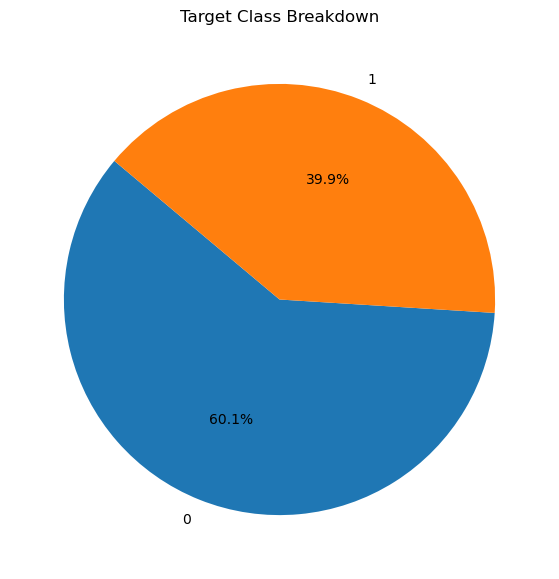

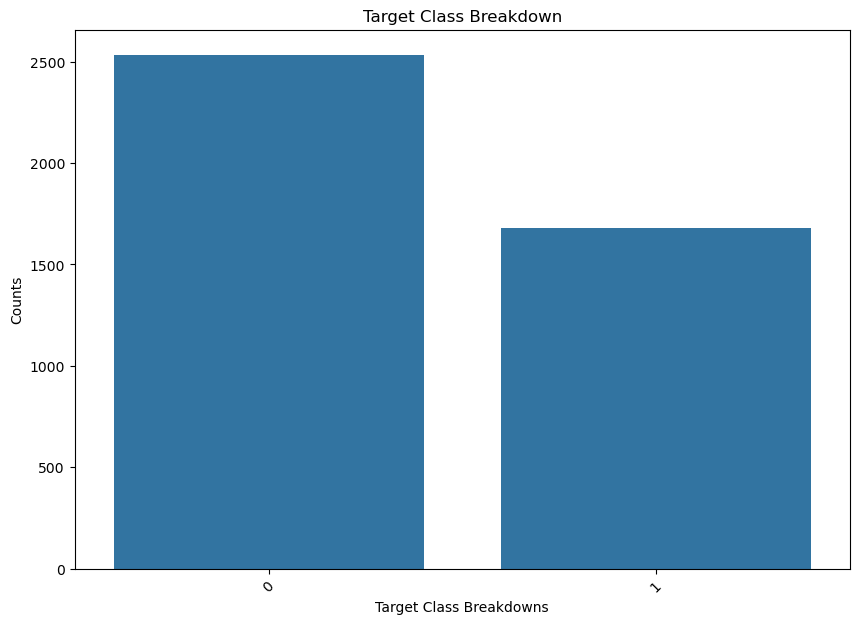

In [7]:
check_class_imbalance(df["spam"])

# Slight Class Imbalance

In [8]:
df.dtypes

word_freq_make                float64
word_freq_address             float64
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                 float64
word_freq_over                float64
word_freq_remove              float64
word_freq_internet            float64
word_freq_order               float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report              float64
word_freq_addresses           float64
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                 float64
word_freq_money               float64
word_freq_hp                  float64
word_freq_hpl                 float64
word_freq_ge

In [9]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,...,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000
mean,0.104366,0.112656,0.291473,0.063078,0.325321,0.096656,0.117475,0.108000,0.091860,0.248420,...,0.040403,0.144048,0.017376,0.281136,0.076057,0.045798,5.383896,52.139905,291.181948,0.398812
std,0.300005,0.454260,0.515719,1.352487,0.687805,0.276030,0.397284,0.410282,0.282144,0.656638,...,0.252533,0.274256,0.105731,0.843321,0.239708,0.435925,33.147358,199.582168,618.654838,0.489712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.627500,7.000000,40.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.073000,0.000000,0.016000,0.000000,0.000000,2.297000,15.000000,101.500000,0.000000
75%,0.000000,0.000000,0.440000,0.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.190000,...,0.000000,0.194000,0.000000,0.331000,0.053000,0.000000,3.706750,44.000000,273.750000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


# Due to the amount of features, we will have to conduct a PCA analysis and determine how many redundant columns are in our dataset.

# Separate Feature Variables

In [36]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [37]:
X, y = shuffled_df.drop("spam", axis=1), shuffled_df["spam"]

    index Model  Cumulative-Variance   N
0       0   PCA             0.707985  23
1       1   PCA             0.721890  24
2       2   PCA             0.734376  25
3       3   PCA             0.747745  26
4       4   PCA             0.760582  27
5       5   PCA             0.772997  28
6       6   PCA             0.784294  29
7       7   PCA             0.796150  30
8       8   PCA             0.808102  31
9       9   PCA             0.818707  32
10     10   PCA             0.830449  33
11     11   PCA             0.841145  34
12     12   PCA             0.851250  35
13     13   PCA             0.861836  36
14     14   PCA             0.871874  37
15     15   PCA             0.881603  38
16     16   PCA             0.890559  39
17     17   PCA             0.900023  40
18     18   PCA             0.908841  41
19     19   PCA             0.917369  42
20     20   PCA             0.925794  43
21     21   PCA             0.933782  44
22     22   PCA             0.941614  45
23     23   PCA 

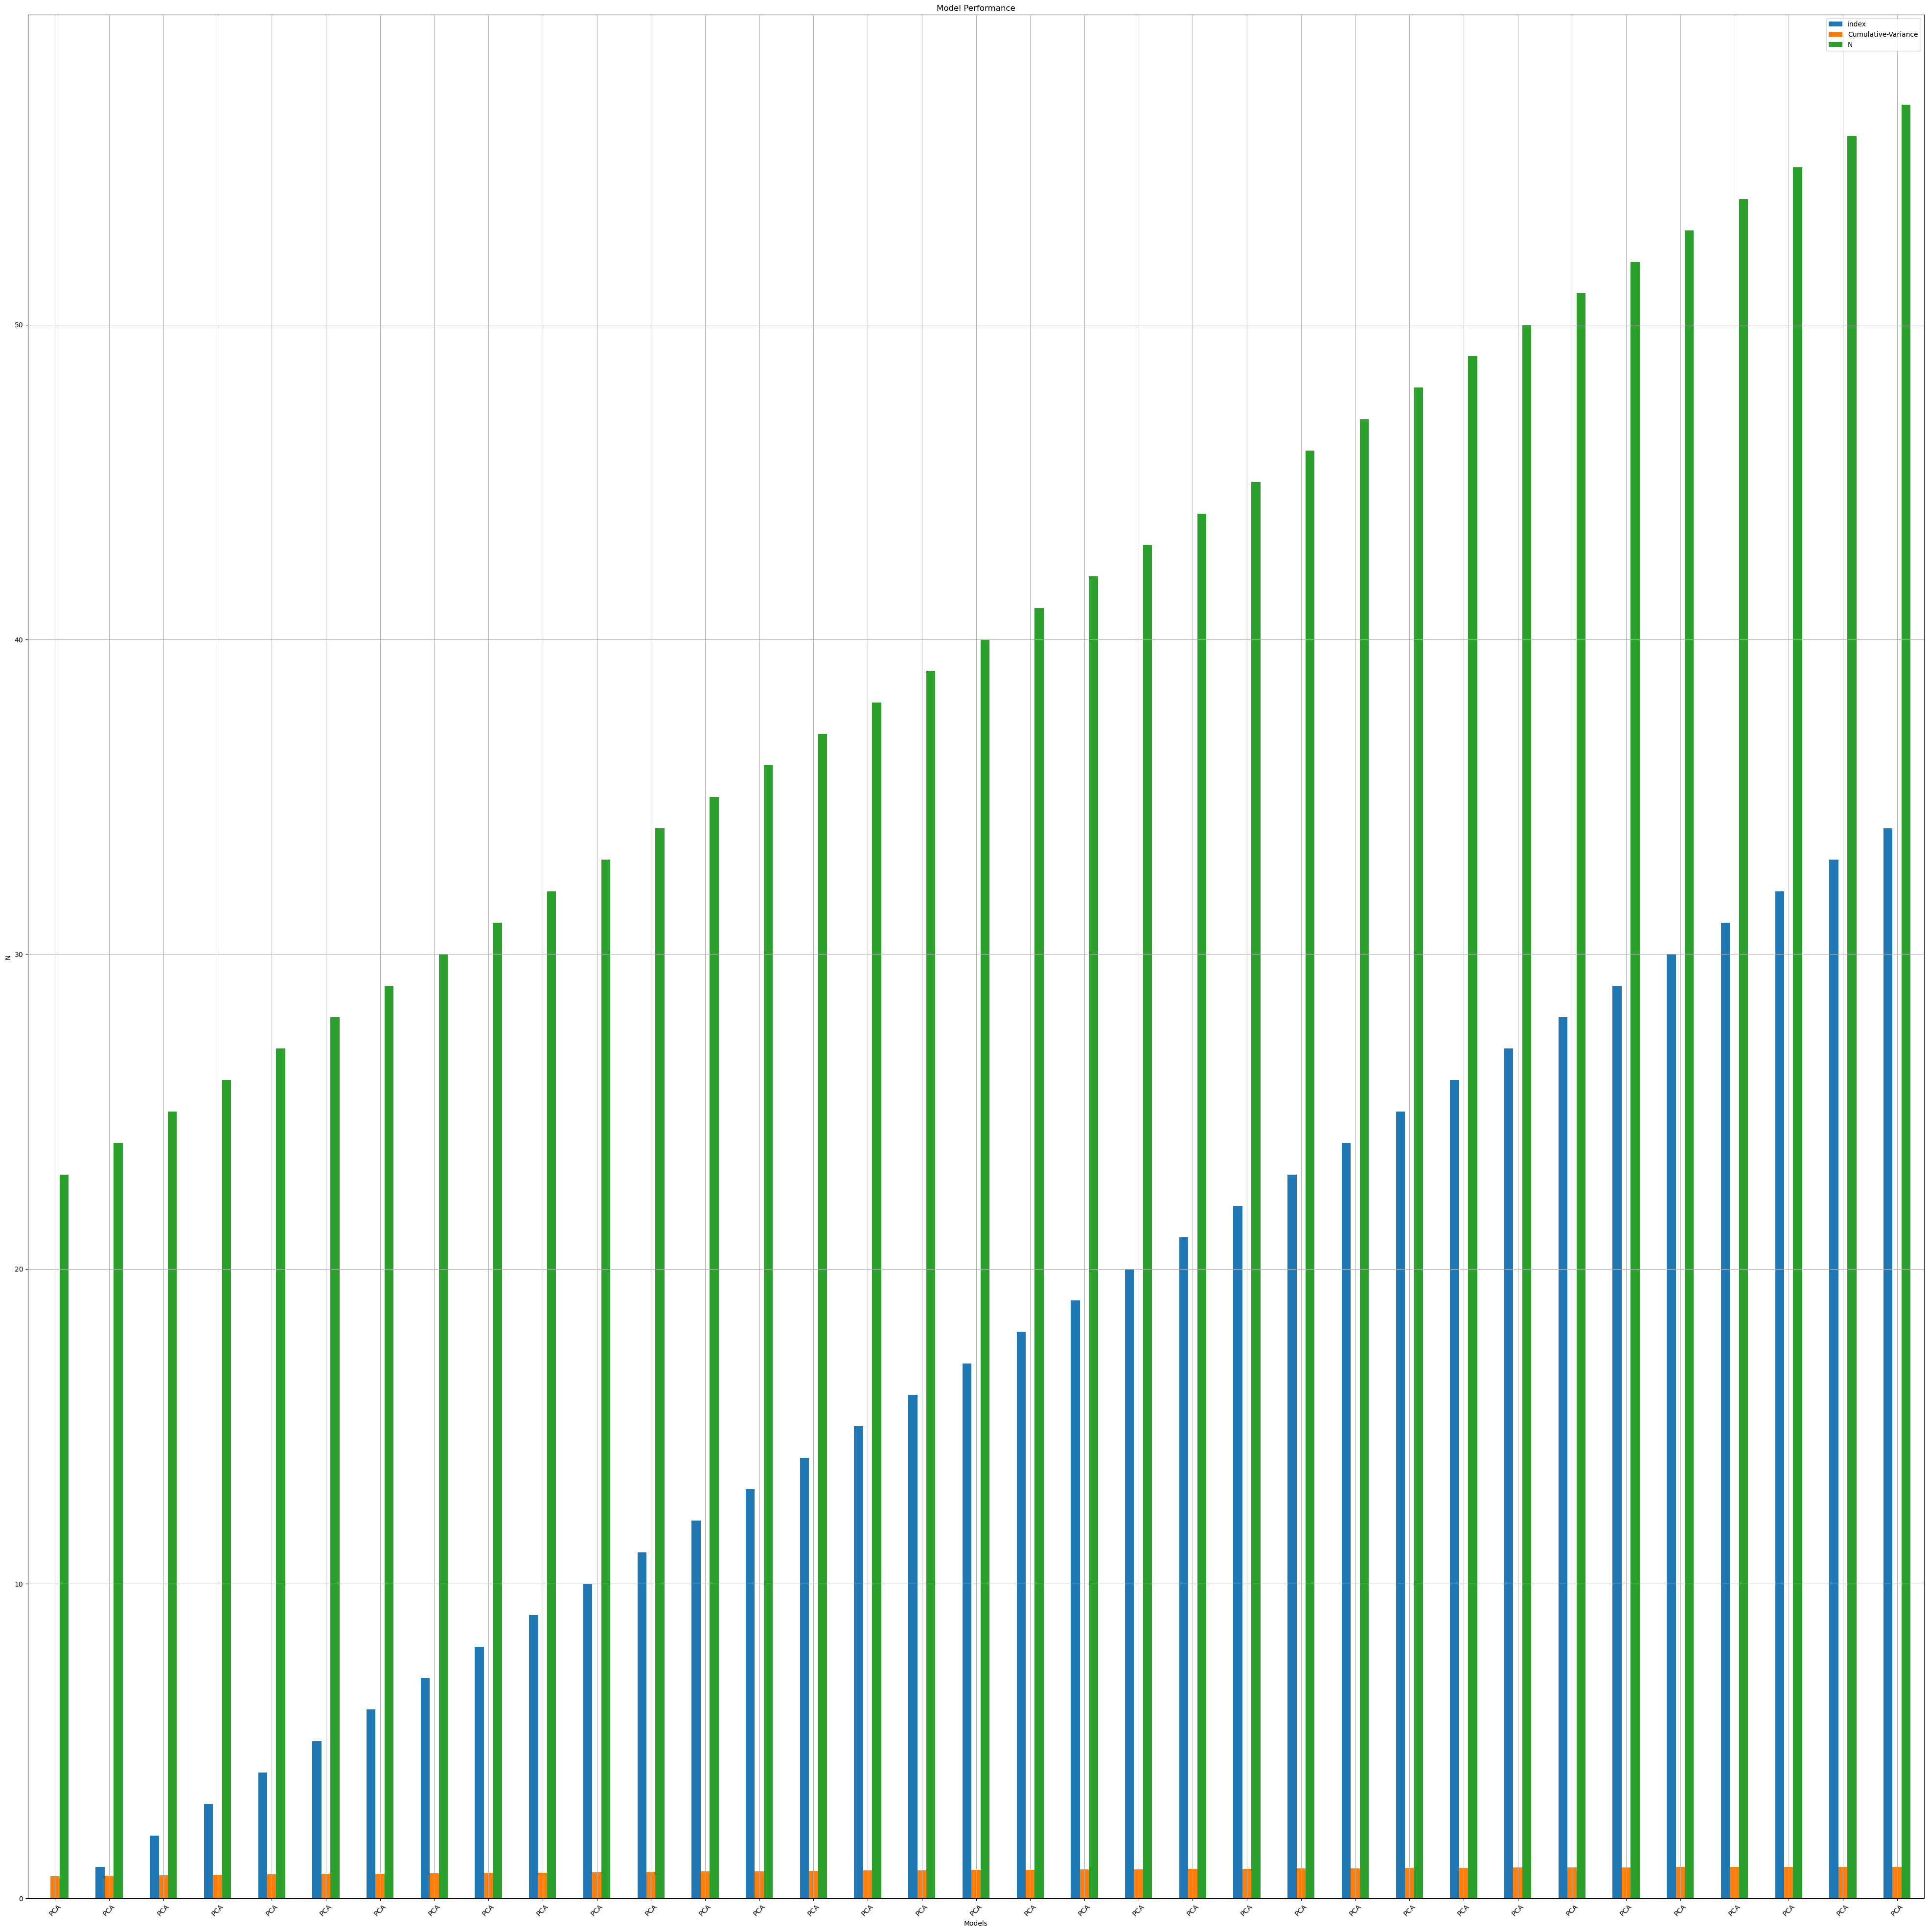

In [41]:
pca_analysis(X)

# 70-100 % of the variance is between 23-57 columns.

# Visuals

<AxesSubplot:>

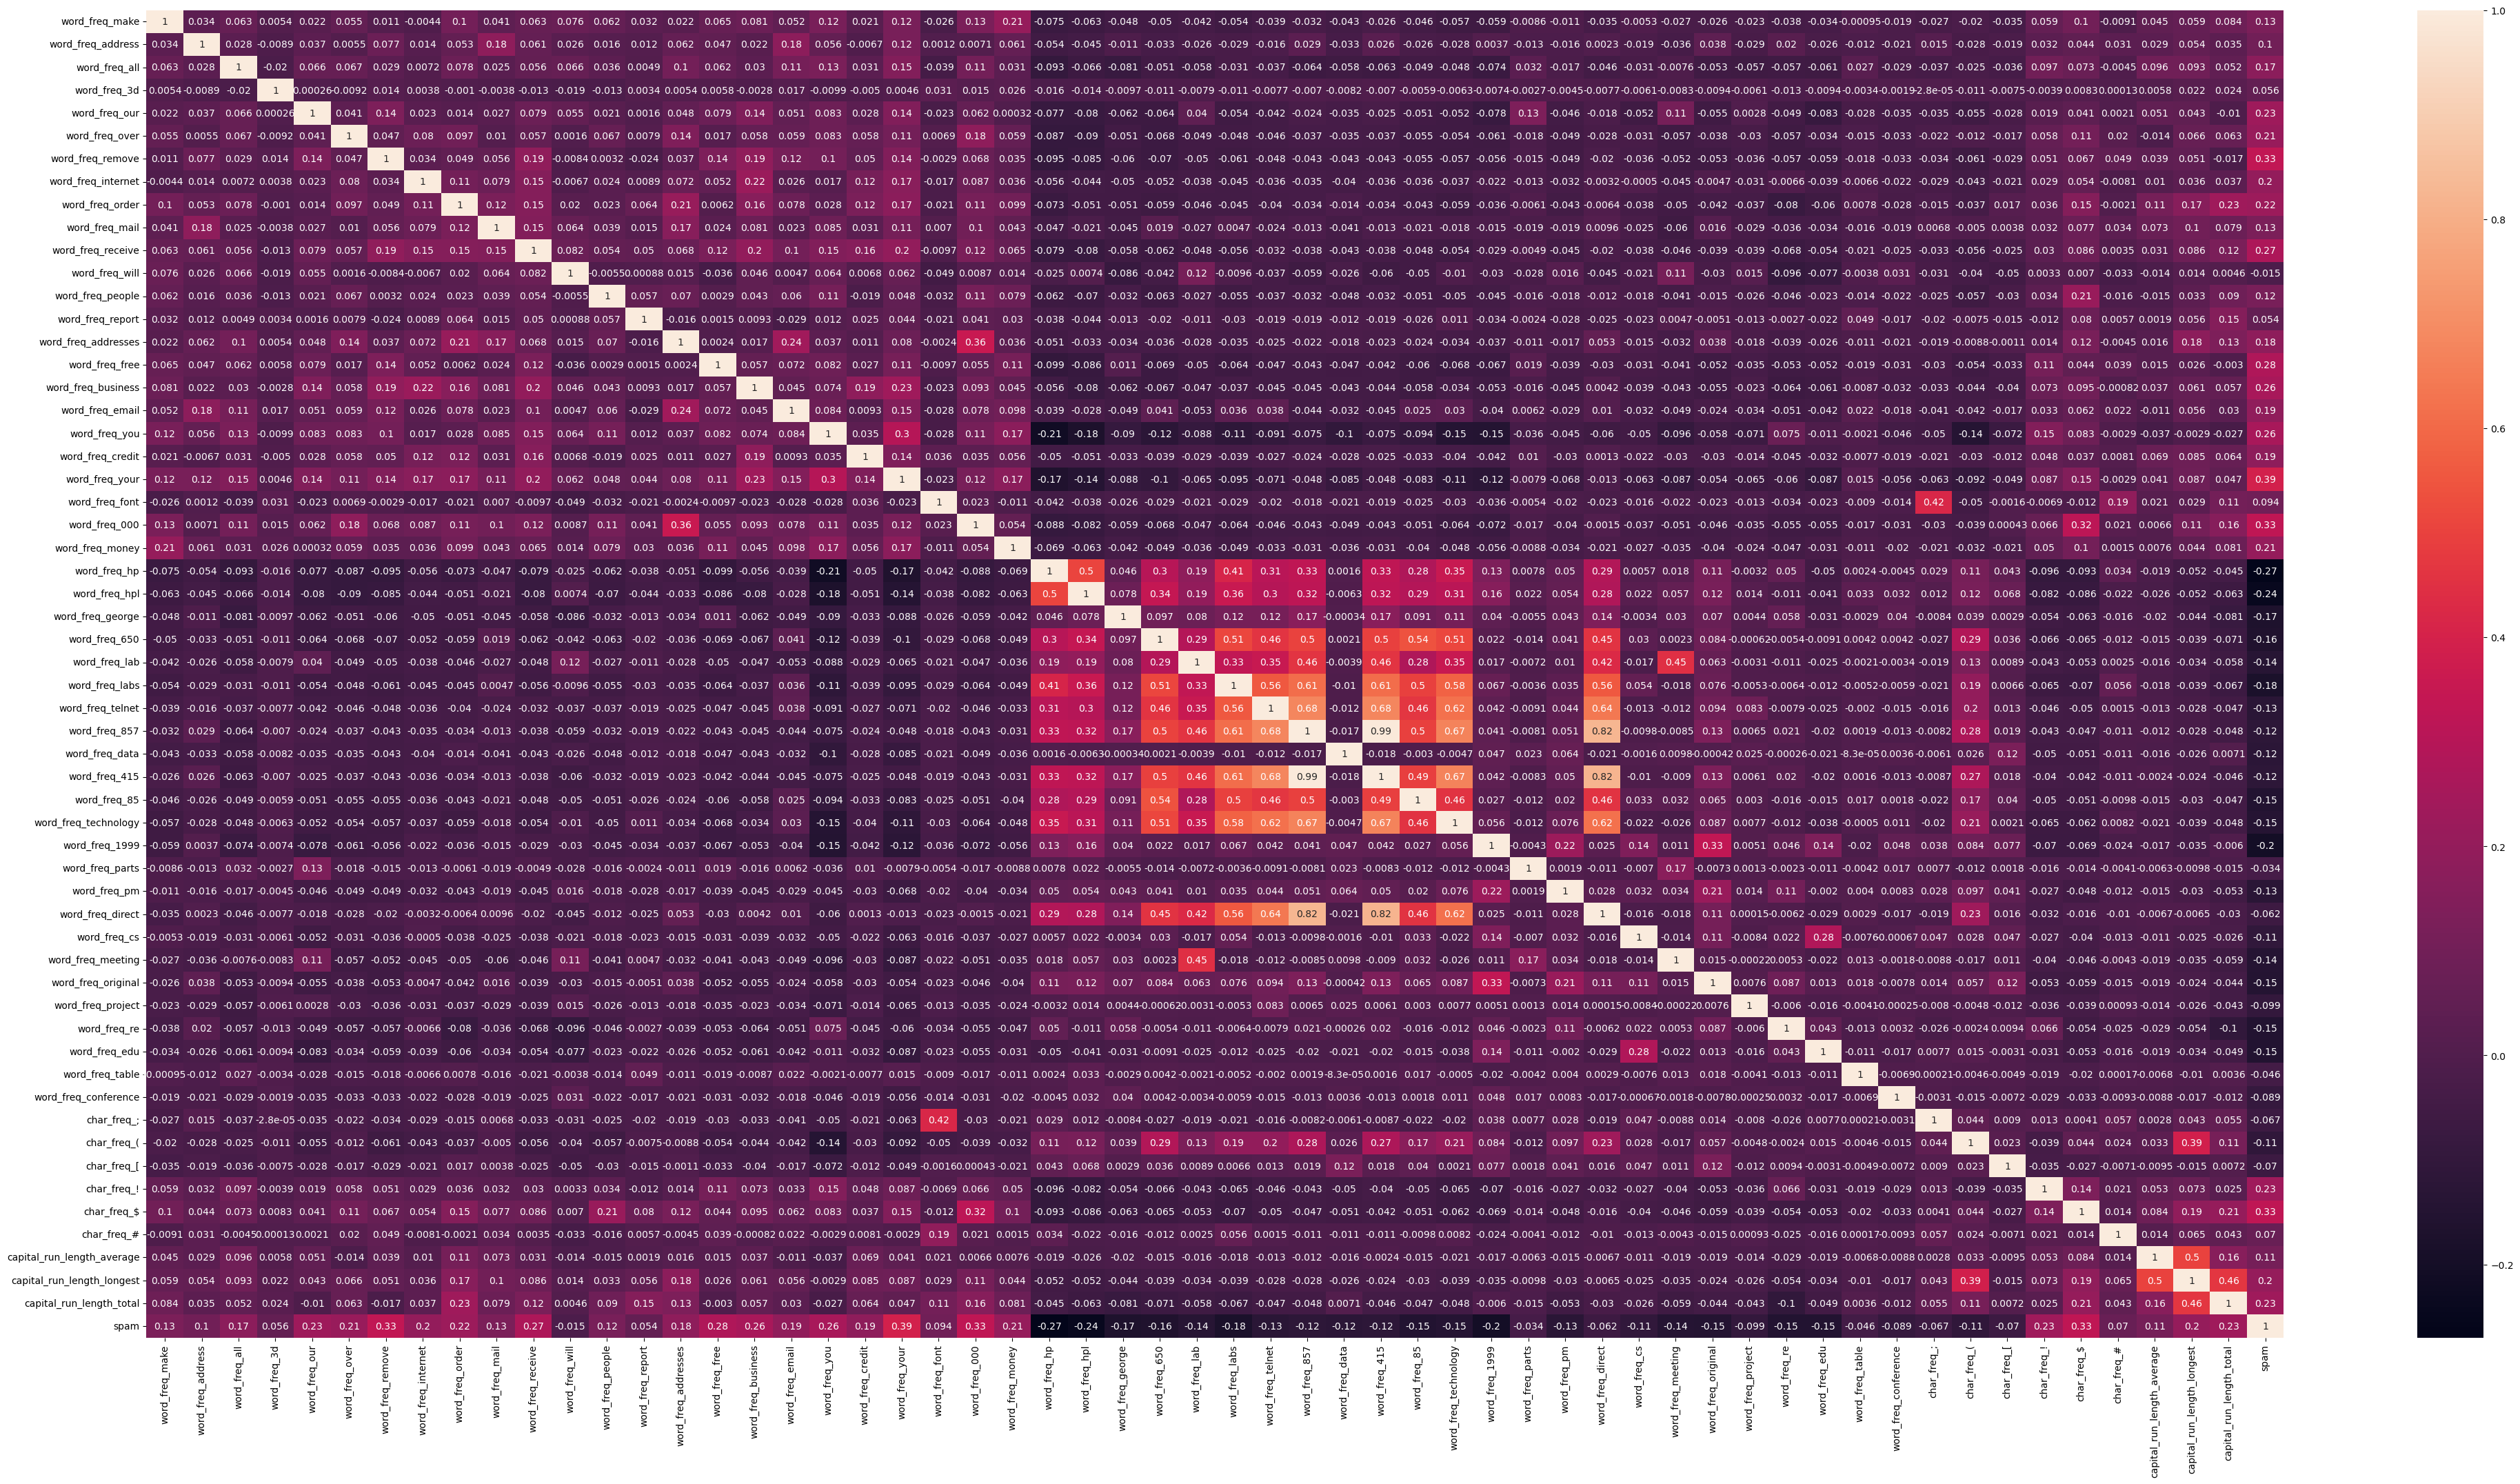

In [11]:
plt.figure(figsize=(50, 25))
sns.heatmap(data=df.corr(), annot=True)

# Metrics

In [48]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)

# Baseline Model Performance

   index  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.399  0.0  0.001     0.399     0.227           1.0   

   precision-Score  F2-Score  
0              1.0     0.399  


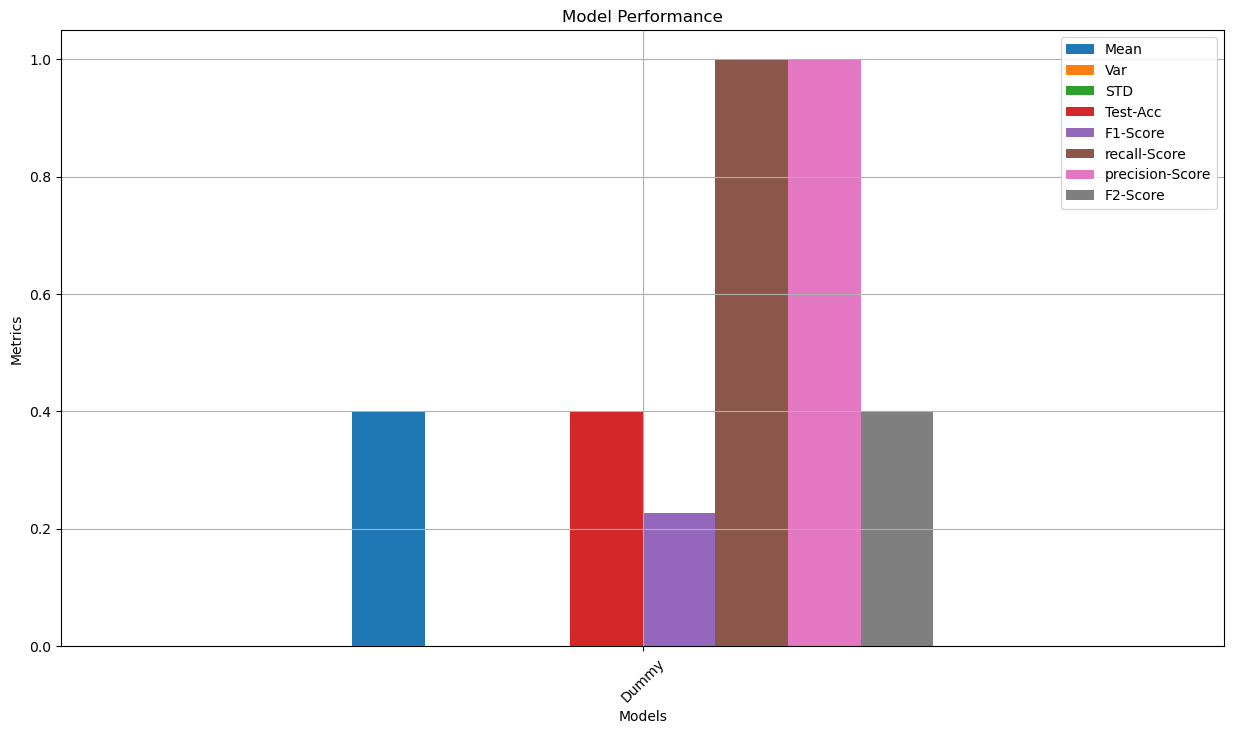

   index  Model  Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.57  0.0  0.001     0.399     0.227           1.0   

   precision-Score  F2-Score  
0              1.0     0.399  


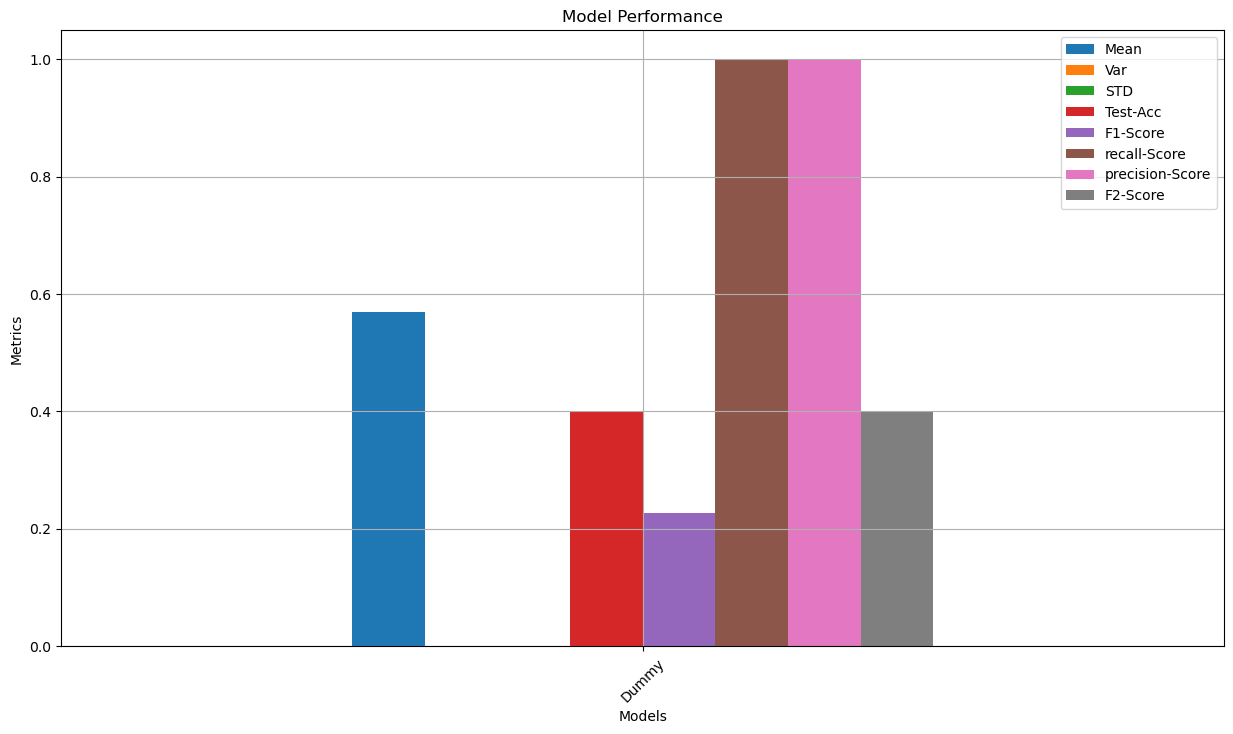

   index  Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy  0.399  0.0  0.001     0.399     0.227           1.0   

   precision-Score  F2-Score  
0              1.0     0.399  


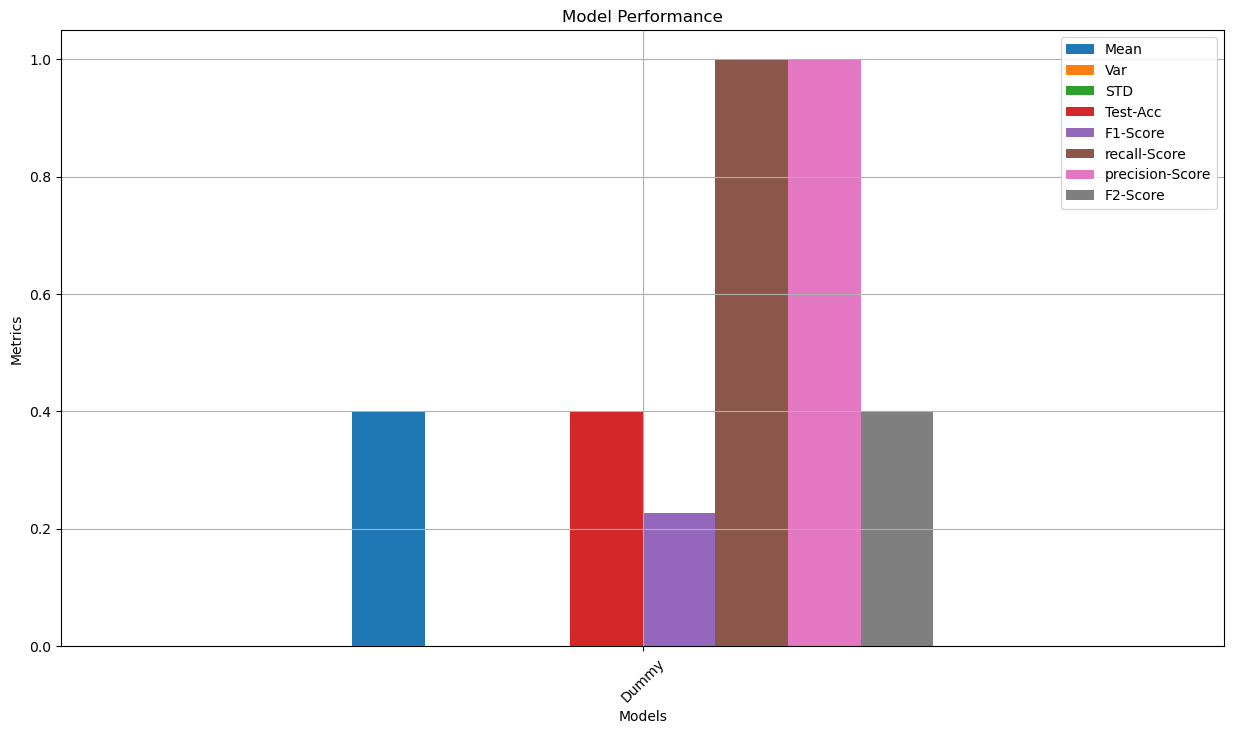

   index  Model  Mean  Var  STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy   1.0  0.0  0.0     0.399     0.227           1.0   

   precision-Score  F2-Score  
0              1.0     0.399  


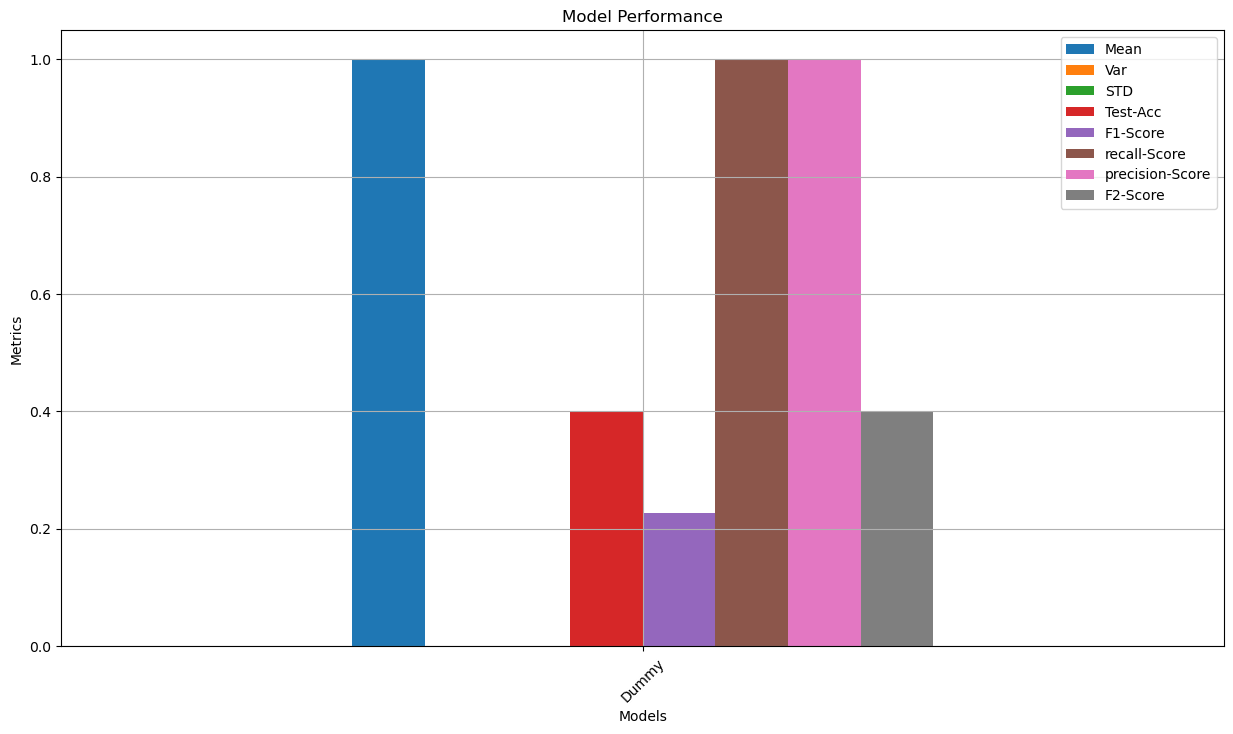

In [59]:
model_names = ["Dummy"]
models = grab_selected_models(model_names)


test_selected_models(model_names, models, X, y, acc_metric)
test_selected_models(model_names, models, X, y, f1_metric)
test_selected_models(model_names, models, X, y, precision_metric)
test_selected_models(model_names, models, X, y, recall_metric)

# Advanced Model Metrics

   index Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   XGB  0.951  0.0  0.010     0.950     0.950         0.937   
1      4   RFC  0.949  0.0  0.010     0.949     0.949         0.919   
2      1   SVC  0.947  0.0  0.012     0.945     0.945         0.916   
3      6   GBC  0.941  0.0  0.011     0.941     0.941         0.909   
4      2   KNN  0.936  0.0  0.012     0.937     0.937         0.895   
5      0    LR  0.935  0.0  0.013     0.934     0.934         0.929   
6      5   DTC  0.903  0.0  0.013     0.899     0.899         0.881   

   precision-Score  F2-Score  
0            0.937     0.937  
1            0.919     0.951  
2            0.916     0.944  
3            0.909     0.941  
4            0.895     0.945  
5            0.929     0.908  
6            0.881     0.868  


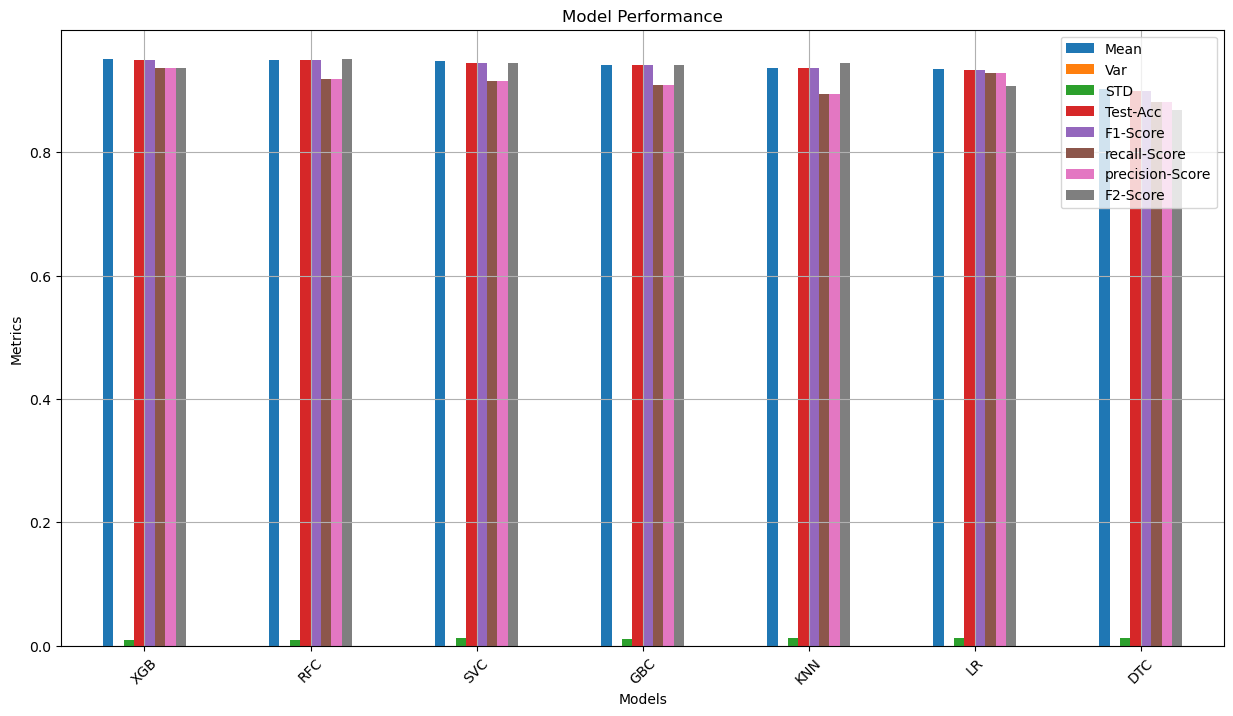

In [60]:
model_names = ["LR", "SVC", "KNN", "XGB", "RFC", "DTC", "GBC"]
models = grab_selected_models(model_names)

test_selected_models(model_names, models, X, y, acc_metric)

   index Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      3   XGB  0.938  0.0  0.013     0.950     0.950         0.937   
1      4   RFC  0.935  0.0  0.013     0.948     0.948         0.920   
2      1   SVC  0.933  0.0  0.015     0.945     0.945         0.916   
3      6   GBC  0.925  0.0  0.014     0.941     0.941         0.909   
4      0    LR  0.919  0.0  0.016     0.934     0.934         0.929   
5      2   KNN  0.917  0.0  0.016     0.937     0.937         0.895   
6      5   DTC  0.882  0.0  0.016     0.900     0.900         0.883   

   precision-Score  F2-Score  
0            0.937     0.937  
1            0.920     0.948  
2            0.916     0.944  
3            0.909     0.940  
4            0.929     0.908  
5            0.895     0.945  
6            0.883     0.867  


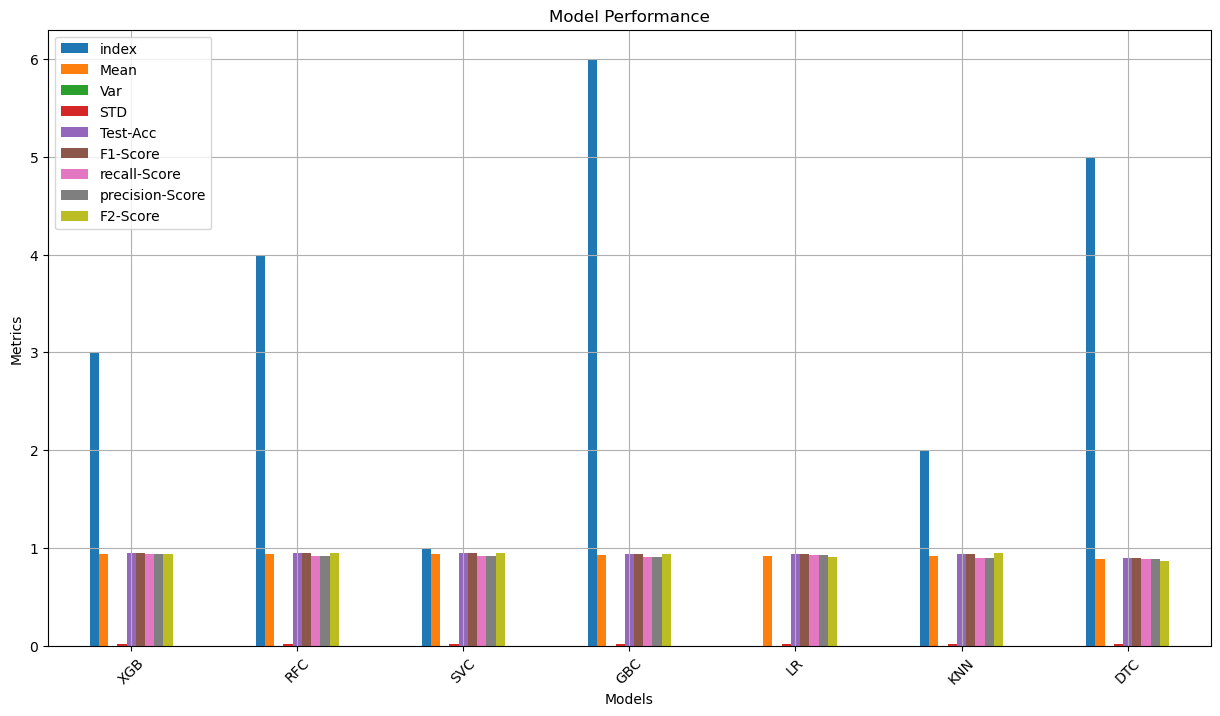

In [57]:
test_selected_models(model_names, models, X, y, f1_metric)

# Test K best columns

# Mutual Information

In [73]:
metric = mutual_info_classif
variance_window = range(10, 58)
model_name = ["XGB"]
model = grab_selected_models(model_name)

test_kbest_columns(model[0], model_name[0], metric, variance_window, X, y)

    index Model   K  F1-Score  F2-Score  recall-Score  precision-Score  \
0      41   XGB  51  0.927007  0.920957      0.916968         0.937269   
1      32   XGB  42  0.925319  0.920290      0.916968         0.933824   
2      34   XGB  44  0.925319  0.920290      0.916968         0.933824   
3      42   XGB  52  0.924201  0.917664      0.913357         0.935305   
4      45   XGB  55  0.923775  0.920767      0.918773         0.928832   
5      36   XGB  46  0.923636  0.919623      0.916968         0.930403   
6      47   XGB  57  0.922937  0.920434      0.918773         0.927140   
7      35   XGB  45  0.922797  0.919291      0.916968         0.928702   
8      46   XGB  56  0.922937  0.920434      0.918773         0.927140   
9      43   XGB  53  0.922937  0.920434      0.918773         0.927140   
10     40   XGB  50  0.922516  0.916999      0.913357         0.931860   
11     33   XGB  43  0.921676  0.916667      0.913357         0.930147   
12     39   XGB  49  0.921533  0.91551

# Notice the gains from 11 to 58 the performance gains are rather minmial almost a 1 % gain from 21 to 58 columns.